In [161]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/trains/train.csv
/kaggle/input/trains/test.csv


In [162]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
import matplotlib.pyplot as plt

In [163]:
df = pd.read_csv("/kaggle/input/trains/train.csv")
df.drop(columns=['id'], inplace=True)

In [164]:
train = df.copy()

In [165]:
train.isna().sum()

titulo                          5387
descripcion                     1619
tipodepropiedad                   46
direccion                      53072
ciudad                           372
provincia                        155
antiguedad                     43555
habitaciones                   22471
garages                        37765
banos                          26221
metroscubiertos                17400
metrostotales                  51467
idzona                         28621
lat                           123488
lng                           123488
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
dtype: int64

Relleno los nans y verifico la feature importance utilizando Random Forest

In [166]:
#Las variables categoricas las relleno indicando que estan vacias
train['ciudad'] = SimpleImputer(strategy='constant', fill_value='ciudadVacia').fit_transform(train[['ciudad']])
train['provincia'] = SimpleImputer(strategy='constant', fill_value='provinciaVacia').fit_transform(train[['provincia']])
train['tipodepropiedad'] = SimpleImputer(strategy='constant', fill_value='tipoVacio').fit_transform(train[['tipodepropiedad']])

In [167]:
#EL titulo y la descripcion las junto y las reemplazo por el largo del texto
train.titulo.fillna('', inplace=True)
train.descripcion.fillna('', inplace=True)
train['texto'] = train['descripcion'] + train['titulo']
train['texto'] = train.texto.str.len()
train.drop(columns=['descripcion', 'titulo'], inplace=True)

In [168]:
#La direccion la dropeo
train.drop(columns = ['direccion'], inplace=True)

In [169]:
#Las categoricas las reemplazo por la cantidad de apariciones
train['ciudad'] = CountEncoder().fit_transform(train['ciudad'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

In [170]:
#La antiguedad la reemplazo por el promedio de antiguedad para la ciudad
aux = train[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
antiguedades = aux.T.to_dict('records').copy()
antiguedades = antiguedades[0]
train.antiguedad.fillna(train.ciudad.map(antiguedades), inplace = True)
train['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['antiguedad']])

In [171]:
#La cantidad de habitaciones las reemplazo por la mediana de habitaciones por tipo de propiedad
aux = train[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
train.habitaciones.fillna(train.tipodepropiedad.map(habts), inplace = True)
train['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['habitaciones']])

In [172]:
#Los garages supongo que no tiene si es nan
train.garages.fillna(0, inplace=True)

In [173]:
#Los banos relleno con 1 ya que es la cantidad minima de banos que tiene normalmente una propiedad
train.banos.fillna(1, inplace=True)

In [174]:
#Para los metros cubiertos y totales relleno con 0 y arreglo para que metros totales sea siempre mayor a metros cubiertos
aux = train.copy()
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
train['metrostotales'] = aux['metrostotalesCorregidos']
train['metroscubiertos'] = aux['metroscubiertosCorregidos']

In [175]:
#El idzona lo relleno con la mediana en la ciudad
aux2 = train[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
train.idzona.fillna(train.ciudad.map(ids), inplace = True)
train['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['idzona']])

In [176]:
#Lo mismo hago para la latitud y la longitud
aux = train[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
train.lat.fillna(train.ciudad.map(lats), inplace = True)
train['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lat']])

aux = train[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
train.lat.fillna(train.ciudad.map(lngs), inplace = True)
train['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(train[['lng']])

In [177]:
#La fecha la separo en 3 columnsa de anio, mes y dia
train['fecha'] = pd.to_datetime(train['fecha'])
train['dia'] = train.fecha.dt.day
train['mes'] = train.fecha.dt.month
train['anio'] = train.fecha.dt.year
train.drop(columns=['fecha'], inplace=True)

In [178]:
#AHora utilizamos random forest para graficar la feature importance
model = RandomForestRegressor(n_estimators = 100, random_state=0, n_jobs=-1, max_depth = 20)

In [179]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio

In [180]:
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

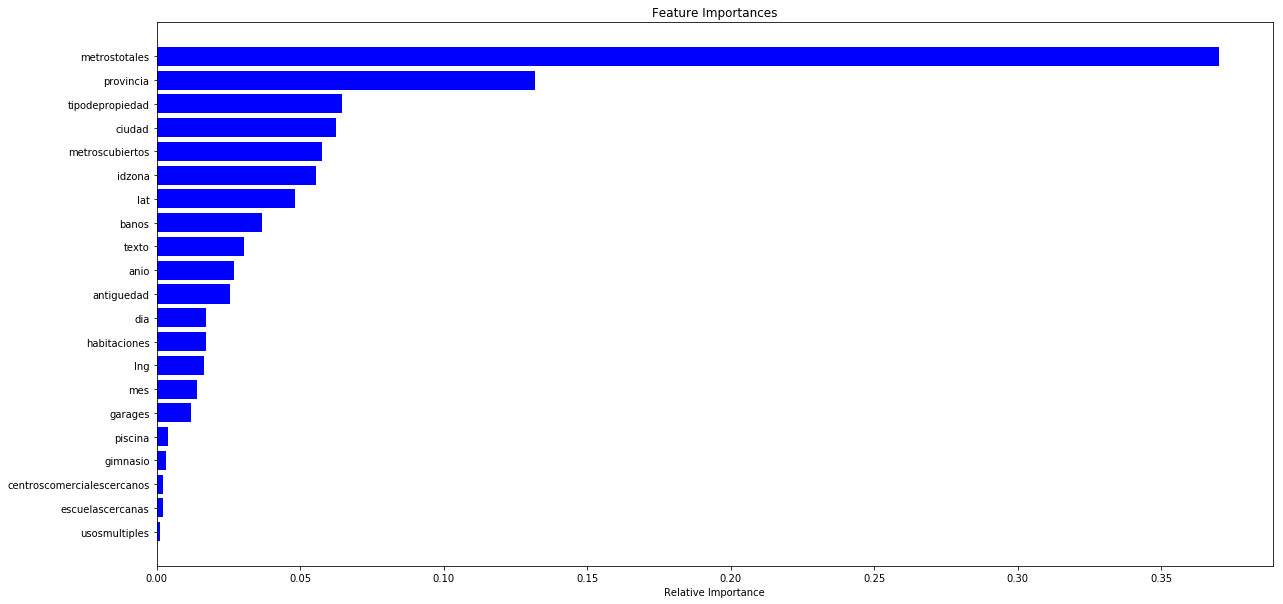

In [181]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Probamos con rellenar los banos con la mediana por tipo de propriedad para ver si mejora la feature importance 

In [182]:
train['banos'] = df['banos']
aux = train[['banos', 'tipodepropiedad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'banos':'median'})
banos = aux.T.to_dict('records').copy()
banos = banos[0]
train.banos.fillna(train.tipodepropiedad.map(lngs), inplace = True)
train.banos.fillna(1, inplace=True)

In [183]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio

In [184]:
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

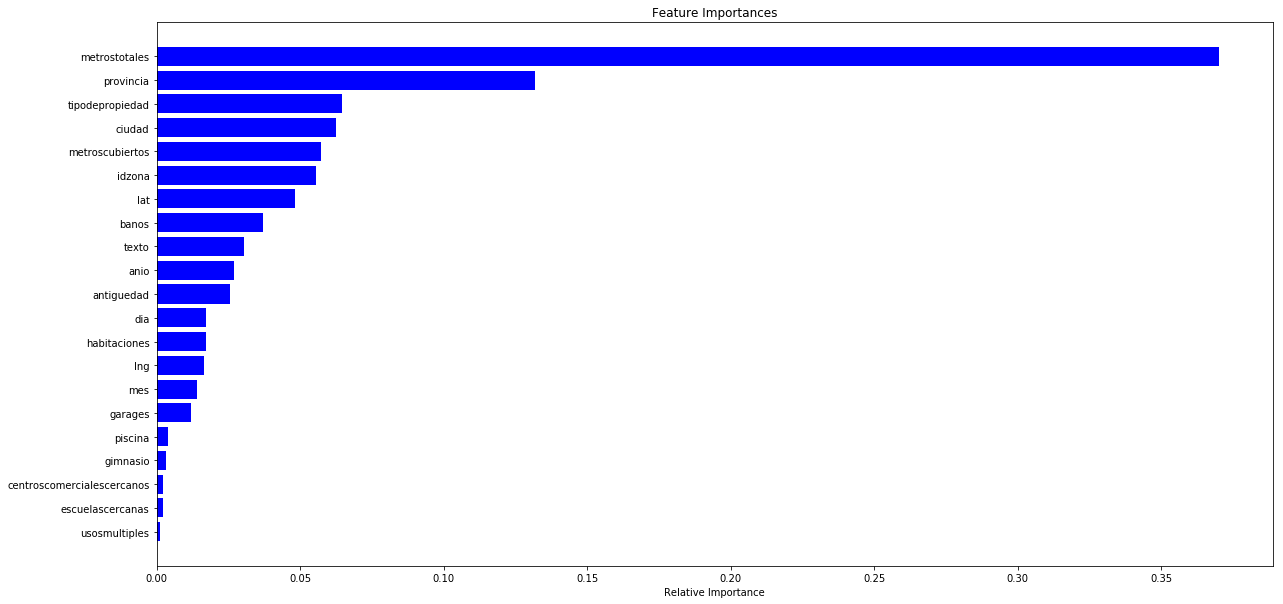

In [185]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Como podemos observar rellenar los banos de esta manera no cambia la feature importance

Ahora probamos con el catBoostEncoder para la ciudad, la provincia y el tipo de propiedad y verificamos como afecta la feature importance

In [186]:
train['ciudad'] = df['ciudad']
train['provincia'] = df['provincia']
train['tipodepropiedad'] = df['tipodepropiedad']

In [187]:
train['ciudad'] = CatBoostEncoder().fit_transform(train['ciudad'], df['precio'])
train['provincia'] = CatBoostEncoder().fit_transform(train['provincia'], df['precio'])
train['tipodepropiedad'] = CatBoostEncoder().fit_transform(train['tipodepropiedad'], df['precio'])

In [188]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio

In [189]:
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

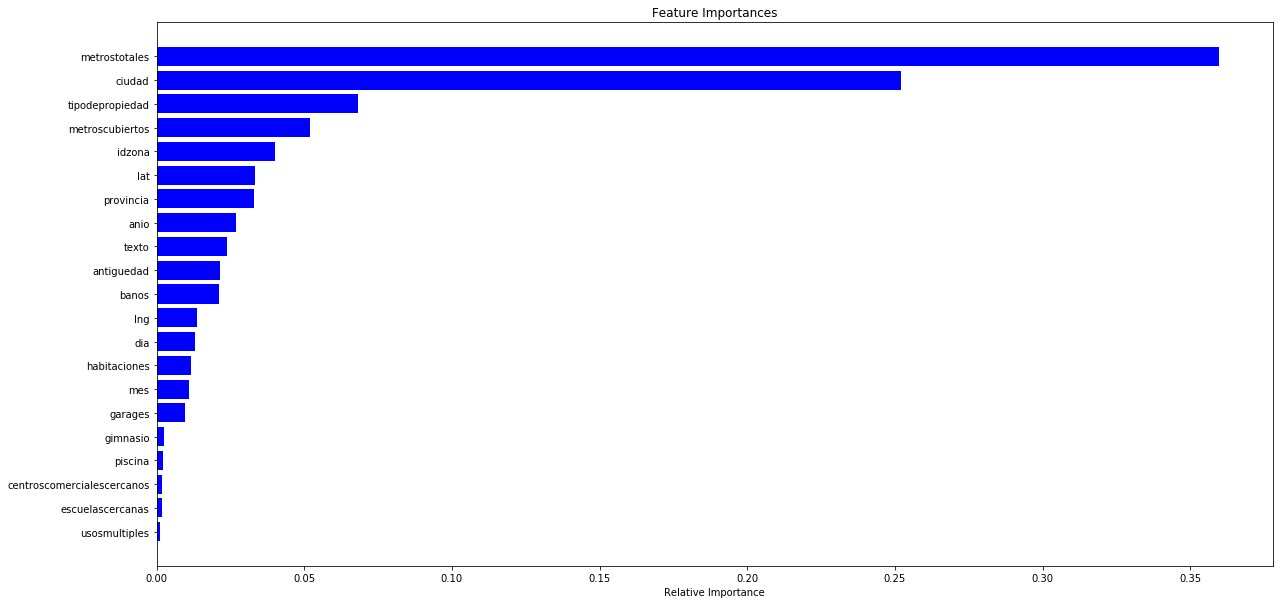

In [190]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Podemos observar que aumento la feature importance para la ciudad, el tipo de propiedad no se vio afectado mientras que la provincia decayo.
Por lo tanto, probamos con solo utilizar cat boost para la ciudad

In [191]:
train['ciudad'] = df['ciudad']
train['provincia'] = df['provincia']
train['tipodepropiedad'] = df['tipodepropiedad']

In [192]:
train['ciudad'] = CatBoostEncoder().fit_transform(train['ciudad'], df['precio'])
train['provincia'] = CountEncoder().fit_transform(train['provincia'])
train['tipodepropiedad'] = CountEncoder().fit_transform(train['tipodepropiedad'])

In [193]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

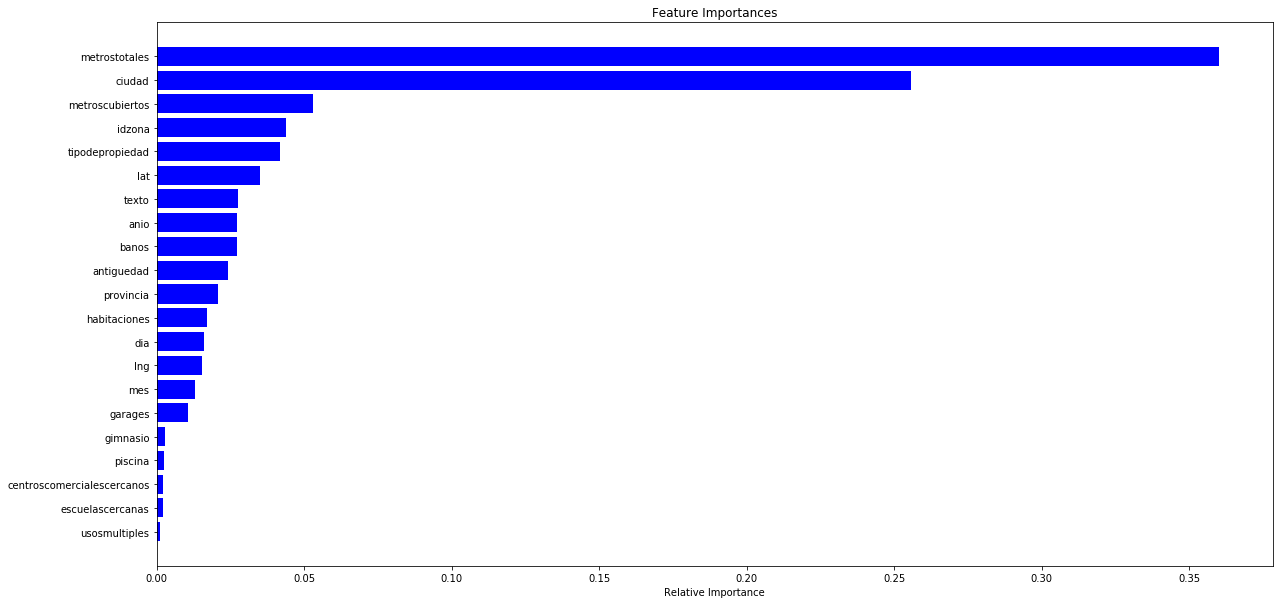

In [194]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Sorprendentemente la provincia sigue empeorando su feature importance por mas que se utilice count encoding para la provincia si se sigue usando cat boost encoder para ciudad

Ahora probamos con crear alguno features para verificar que nivel de importancia tienen y como afectan a los demas features

In [195]:
#Agregamos la cantidad de publicaciones por mes
aux = train[['mes', 'anio']].copy()
aux['cantidad'] =  1
aux['cantidad'] = aux.groupby(['mes', 'anio']).transform('sum')
train['publicacionesEnMes'] = aux['cantidad']

In [197]:
aux = train[['metrostotales', 'tipodepropiedad']].copy()
aux['metrosPromedioPorTipo'] = aux.groupby('tipodepropiedad').transform('mean')
train['metrosPromedioPorTipo'] = aux['metrosPromedioPorTipo']

In [198]:
aux = train[['metrostotales', 'ciudad']].copy()
aux['metrosPromedioPorCiudad'] = aux.groupby('ciudad').transform('mean')
train['metrosPromedioPorCiudad'] = aux['metrosPromedioPorCiudad']

In [199]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

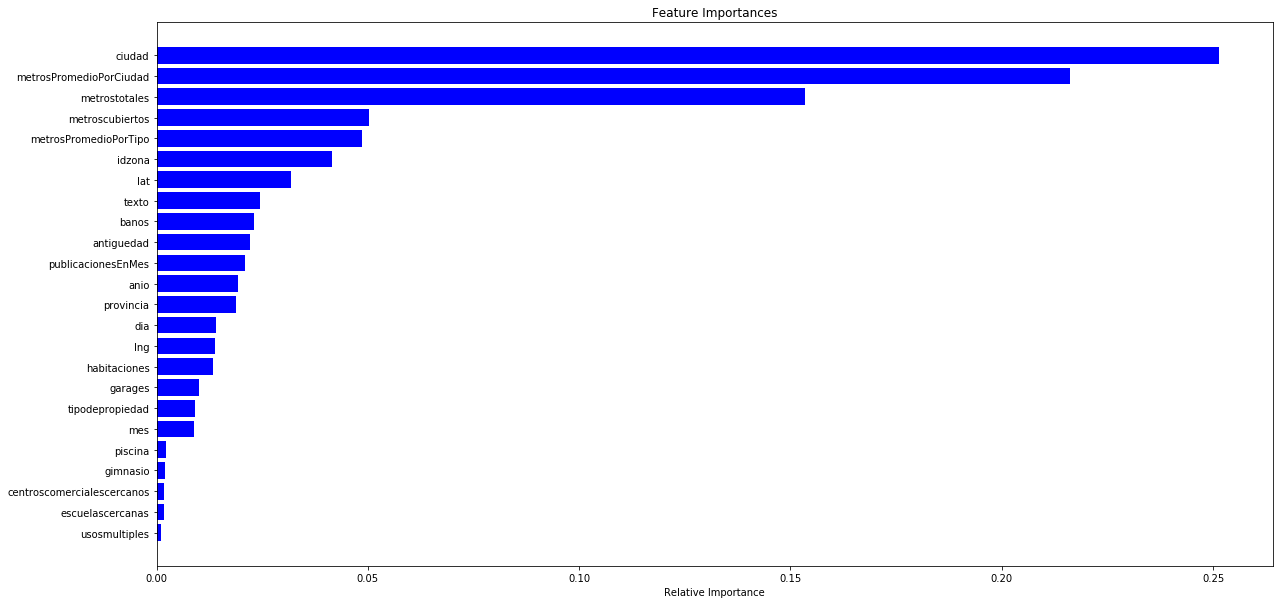

In [200]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Ahora agregamos features generados a partir de los precios

In [201]:
aux = train[['precio', 'ciudad', 'metrostotales']].copy()
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('ciudad').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['precioPromedioM2PorCiudad'] = train.ciudad.map(precioPromedio)

In [202]:
aux = train[['precio', 'tipodepropiedad', 'metrostotales']].copy()
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('tipodepropiedad').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['precioPromedioM2PorTipo'] = train.tipodepropiedad.map(precioPromedio)

In [203]:
aux = train[['precio', 'idzona', 'metrostotales']].copy()
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('idzona').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['precioPromedioM2PorZona'] = train.idzona.map(precioPromedio)

In [205]:
aux = train[['precio', 'mes', 'anio', 'metrostotales']].copy()
aux['mes-anio'] = aux.mes + aux.anio
aux['precioMetro'] = aux['precio']/aux['metrostotales']
aux = aux.groupby('mes-anio').agg({'precioMetro':'mean'})
precioPromedio = aux.T.to_dict('records').copy()
precioPromedio = precioPromedio[0]
train['mes-anio'] = train.mes + train.anio
train['precioPromedioM2PorMes'] = train['mes-anio'].map(precioPromedio)
train.drop(columns=['mes-anio'], inplace = True)

In [ ]:
train_x = train.drop(columns=['precio']).copy()
train_y = train.precio
model.fit(train_x, train_y)

In [ ]:
features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
fig= plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()